In [ ]:
import csv
import random
from tqdm import tqdm
import os

# Set random seed for reproducibility
random.seed(0)

# Function to read the CSV and create a cell count map
def read_cell_count_data(csv_file):
    cell_count_map = {}
    with open(csv_file, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        for row in reader:
            cell_count, img_path, msk_path = row
            if int(cell_count) not in cell_count_map:
                cell_count_map[int(cell_count)] = []
            cell_count_map[int(cell_count)].append((img_path, msk_path))
    return cell_count_map

# Read the data and create a cell count map
cell_count_map = read_cell_count_data("cell_count_data.csv")

# Filter and randomly select 100 images and masks for each cell count
for cell_count in list(cell_count_map):
    if len(cell_count_map[cell_count]) < 100:
        del cell_count_map[cell_count]
    else:
        cell_count_map[cell_count] = random.sample(cell_count_map[cell_count], 100)

# Create a directory for the CSV files
os.makedirs("stats_csv", exist_ok=True)

# Write the filtered data to separate CSV files
for cell_count, data in tqdm(cell_count_map.items()):
    with open(f"stats_csv/cell_count_{cell_count}.csv", mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Image_Path", "Mask_Path"])
        for img_path, msk_path in data:
            writer.writerow([img_path, msk_path])

print("CSV files created for each cell count.")


In [ ]:
import os
import subprocess
from natsort import natsorted


# Path to the .datasets directory
datasets_dir = './datasets'
models_dir = './experiments_daug'


# Iterate over directories inside .datasets
for cell_count_model in natsorted(os.listdir(models_dir)):

    # Construct the command
    command = [
        'python', 'gen_RES_test_stats.py',
        '--input_seq', './stats_csv',
        '--output_seq', './results_stats_aug',
        '--model_path', './experiments_daug/' + cell_count_model + '/ckpts/*.pth',
    ]

    # Run the command
    subprocess.run(command)
    print(cell_count_model+': model done!')


In [ ]:
import numpy as np
from PIL import Image
from sklearn.metrics import mean_squared_error
from glob import glob
from natsort import natsorted
import os
from multiprocessing import Pool
from tqdm import tqdm

def compute_dice(gt_binary, pred_binary):
    intersection = np.sum(gt_binary * pred_binary)
    return 2. * intersection / (np.sum(gt_binary) + np.sum(pred_binary))

def compute_mse(gt, pred):
    return mean_squared_error(gt.flatten(), pred.flatten())

def convert_rgb_to_label(msk_rgb):
    # Convert the mask image to a NumPy array
    msk_np = np.array(msk_rgb)

    # Flatten the 3D RGB array to a 2D array where each RGB pixel is a single number
    flat_rgb = np.dot(msk_np, [65536, 256, 1])  # This line combines RGB channels uniquely
    unique_colors, flat_labels = np.unique(flat_rgb, return_inverse=True)

    # Reshape the flat_labels array to the original image shape
    label_image = flat_labels.reshape(msk_np.shape[:2])

    # Convert labels to start from 1 instead of 0
    # label_image += 1

    return Image.fromarray(label_image.astype(np.uint16)).resize((512, 512), Image.NEAREST)


def process_model(model):
    mse_model_results = []
    dice_scores = []
    pred_model_probs = natsorted(glob(f'./results_stats/{model}/cell_count_*/*.tif'))

    for gt_path, pred_prob_path in zip(gt_labels, pred_model_probs):
        # gt_lbl = np.array(Image.open(gt_path).resize((512,512), Image.NEAREST))
        gt_lbl = np.array(convert_rgb_to_label(Image.open(gt_path)))
        pred_prob_img = np.array(Image.open(pred_prob_path))
        cell_count = int(pred_prob_path.split('/')[3].split('_')[2])

        gt_binary = (gt_lbl > 0).astype(int)
        pred_binary = (pred_prob_img > 0.5).astype(int)

        mse_model_results.append(compute_mse(gt_binary, pred_prob_img))
        dice_scores.append(compute_dice(gt_binary, pred_binary))

    return model, cell_count, mse_model_results, dice_scores

models = natsorted(os.listdir('./results_stats'))

# List to store all image paths
gt_labels = []

# Iterate over each file in the folder
for file_name in natsorted(os.listdir('./stats_csv')):
    # Check if the file is a CSV file
    if file_name.endswith('.csv'):
        file_path = os.path.join('./stats_csv', file_name)
        with open(file_path, mode='r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip the header row
            for row in reader:
                mask_path = row[1]  # Assuming the image path is the first column
                gt_labels.append(mask_path)

# Parallel processing with tqdm for progress tracking
with Pool() as pool:
    results = list(tqdm(pool.imap(process_model, models), total=len(models)))

mse_results = {}
dice_results = {}

for model, cell_count, mse_model_results, model_dice_scores in results:
    mse_results[model][cell_count] = mse_model_results
    dice_results[model][cell_count] = model_dice_scores


Optimal Cell Count between: 32 and 40
FG Ratio between: 38.91029357910156% and 53.75213623046875%


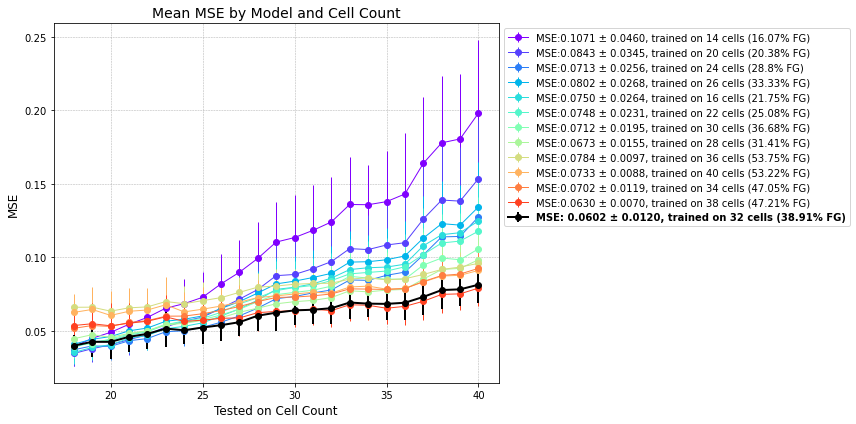

In [91]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from collections import defaultdict


def calculate_foreground_ratio(labels):
    total_pixels = 0
    foreground_pixels = 0
    for label_path in labels:
        label = np.array(Image.open(label_path))
        foreground_pixels += np.sum(label > 0)
        total_pixels += label.size
    return foreground_pixels / total_pixels



def load_results_from_csv(filename):
    results = {}
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header
        for row in reader:
            model = row[0]
            cell_count = int(row[1])
            scores = list(map(float, row[2].split(', ')))
            results[(model, cell_count)] = scores
    return results

# Assuming mse_results is loaded correctly
mse_results = load_results_from_csv('mse_results.csv')

# Aggregate scores by model and cell count
model_cell_aggregated_scores = defaultdict(lambda: defaultdict(list))
for (model, cell_count), scores in mse_results.items():
    if cell_count>=40:
        model_cell_aggregated_scores[model][cell_count].extend(scores)

# Sort models by their average MSE
sorted_models = sorted(model_cell_aggregated_scores.keys(), key=lambda m: np.mean([np.mean(scores) for scores in model_cell_aggregated_scores[m].values()]), reverse=True)
lowest_mse_model = sorted_models[-1]

# List models
models = natsorted(os.listdir('./results_stats_no_aug'))

# Extract all unique cell counts from models
unique_cell_counts = []
for model in models:
    model_cell_count = model.split('_')[2]
    unique_cell_counts.append(model_cell_count)

# Calculate foreground ratios for these cell counts
foreground_ratios = {}
for model, cell_count in zip(models, unique_cell_counts):
    train_labels = natsorted(glob(f'./datasets/cell_count_{cell_count}/train/masks/*.tif'))
    # Assuming calculate_foreground_ratio function is defined
    foreground_ratio = calculate_foreground_ratio(train_labels)
    foreground_ratios[model] = foreground_ratio


# Take the top 5 models with the best MSE
top_5_models = sorted_models[-5:]

# Extract cell counts and foreground ratios for these models
cell_counts_top_5 = [int(model.split('_')[2]) for model in top_5_models]
fg_ratios_top_5 = [foreground_ratios[str(model)]*100 for model in top_5_models]

# Calculate mean and standard deviation for cell counts and FG ratios
min_cell_count = np.min(cell_counts_top_5)
max_cell_count = np.max(cell_counts_top_5)

min_fg_ratio = np.min(fg_ratios_top_5)
max_fg_ratio = np.max(fg_ratios_top_5)

# Display the results
print(f"Optimal Cell Count between: {min_cell_count} and {max_cell_count}")
print(f"FG Ratio between: {min_fg_ratio}% and {max_fg_ratio}%")

# Set plot size for better visibility
plt.figure(figsize=(12, 6))

# Generate unique colors for each model using a colormap
colors = cm.rainbow(np.linspace(0, 1, len(sorted_models)))

# Store handles for custom legend
handles = []

for i, model in enumerate(sorted_models):
    if model == lowest_mse_model:
        continue  # Skip the lowest MSE model for now
    
    cell_counts = sorted(model_cell_aggregated_scores[model].keys())
    cell_counts = cell_counts[:23]
    mean_mse_scores = [np.mean(model_cell_aggregated_scores[model][count]) for count in cell_counts]
    std_mse_scores = [np.std(model_cell_aggregated_scores[model][count]) for count in cell_counts]

    mean_mse = np.mean(mean_mse_scores)
    std_mse = np.std(mean_mse_scores)
    
    model_legend = model.split('_')[2]
    mean_mse, std_mse = format(round(mean_mse, 4), '.4f'), format(round(std_mse, 4), '.4f')

    label_text = f'MSE:{mean_mse} ± {std_mse}, trained on {model_legend} cells ({round(foreground_ratios[model]*100,2)}% FG)'
    # line, = plt.plot(cell_counts, mean_mse_scores, marker='o', linestyle='-', color=colors[i], lw=1)
    line = plt.errorbar(cell_counts, mean_mse_scores, yerr=std_mse_scores, fmt='o', linestyle='-', color=colors[i], lw=1)
    handles.append((line, label_text))

# Plotting the lowest MSE model last so it's on top
cell_counts_lowest = sorted(model_cell_aggregated_scores[lowest_mse_model].keys())
cell_counts_lowest = cell_counts_lowest[:23]
mean_mse_scores_lowest = [np.mean(model_cell_aggregated_scores[lowest_mse_model][count]) for count in cell_counts_lowest]
mean_mse_lowest = np.mean(mean_mse_scores_lowest)

std_mse_scores_lowest = [np.std(model_cell_aggregated_scores[lowest_mse_model][count]) for count in cell_counts_lowest]

std_mse_lowest = np.std([np.mean(model_cell_aggregated_scores[lowest_mse_model][count]) for count in cell_counts_lowest])
mean_mse_lowest, std_mse_lowest = format(round(mean_mse_lowest, 4), '.4f'), format(round(std_mse_lowest, 4), '.4f')

str_lowest_mse_model = lowest_mse_model.split('_')[2]
label_text_lowest = f'MSE: {mean_mse_lowest} ± {std_mse_lowest}, trained on {str_lowest_mse_model} cells ({round(foreground_ratios[lowest_mse_model]*100,2)}% FG)'

line_lowest = plt.errorbar(cell_counts_lowest, mean_mse_scores_lowest, yerr=std_mse_scores_lowest, fmt='o', linestyle='-', color='black', lw=2)
# line_lowest, = plt.plot(cell_counts_lowest, mean_mse_scores_lowest, marker='o', linestyle='-', color='black', lw=2)
handles.append((line_lowest, label_text_lowest))

# Custom legend
legend = plt.legend([h[0] for h in handles], [h[1] for h in handles], loc='upper left', bbox_to_anchor=(1, 1))
for i, text in enumerate(legend.get_texts()):
    if sorted_models[i] == lowest_mse_model:
        text.set_weight('bold')  # Set the specific text to bold


# Grid, labels, title
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Tested on Cell Count', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Mean MSE by Model and Cell Count', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()

plt.savefig('./pdfs/validation 100 imgs per cell count (aug 18-40).pdf')
plt.show()